In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import scipy
import random
import matplotlib.image as mpimg
import networkx as nx

### DEFINING FUNCTIONS

## Constructing ground truth matrices

In [2]:
def get_ground_truth_dict():
    
    c_2_0 = np.random.uniform(0.2,1)
    c_2_1 = np.random.uniform(0.2,1)
    c_1_0 = np.random.uniform(0.2,1)
    c5 = np.random.uniform(0.2,1)
    
    
    ground_truth_dict = {'common_input':np.array([[0, 0, 0],
                                                     [0, 0, 0],
                                                     [c_2_0, c_2_1, 0]]),
                         
                         'indirect_connections':np.array([[0, 0, 0],
                                                          [c_1_0, 0, 0],
                                                          [0, c_2_1,  0]]),
                         
                         'volume_conduction':np.array([[0, 0, 0],
                                                [0, 0, 0],
                                                [c_2_0, 0, 0]])}

    return ground_truth_dict

### Setting signal parameters

In [3]:
confounder_list = ['common_input', 'indirect_connections', 'volume_conduction']

def simulate_confounder(confounder):

    #setting parameters of signal
    sfreq = 250 # Hz
    tmin = 0 # s
    tmax = 100 # s
    time = np.arange(tmin, tmax, 1/sfreq) 
    
    
    f0 = np.random.randint(1,41)  
    f1 = np.random.randint(1,41)  
    f2 = np.random.randint(1,41)  
    
    """
    #signals of 100s duration, 250 Hz sampling frequency, randomly chosen frequency
    signal0 = np.sin(2*np.pi*f0*time)
    signal1 = np.sin(2*np.pi*f1*time)
    signal2 = np.sin(2*np.pi*f2*time)
    
    """

    #random white noise time series
    noise0 = np.random.randn(len(time))
    noise1 = np.random.randn(len(time))
    noise2 = np.random.randn(len(time))

    #gains
    g0 = g1 = g2 = 1

    
    #Factor scaling amplitude of noise
    alpha0 = np.random.uniform(0.01, 0.5)
    alpha1 = np.random.uniform(0.01, 0.5)
    alpha2 = np.random.uniform(0.01, 0.5)

    
    #signal to noise ratio
    snr0 = g0/alpha0
    snr1 = g1/alpha1
    snr2 = g2/alpha2

    """
    #phase
    phase_2_0 = np.random.uniform(0,2)*np.pi
    phase_2_1 = np.random.uniform(0,2)*np.pi
    phase_0_1 = np.random.uniform(0,2)*np.pi

    #delays in seconds
    tau2_0 = phase_2_0/(2*np.pi*f0) #from 3 to 1
    tau2_1 = phase_2_1/(2*np.pi*f1) #from 3 to 2
    tau0_1 = phase_0_1/(2*np.pi*f2) #from 1 to 2
    
    #Time lags in samples
    lag2_0 = np.int64(np.round(tau2_0*f0))
    lag2_1 = np.int64(np.round(tau2_1*f1))
    lag0_1 = np.int64(np.round(tau0_1*f2))
    """
    
    #c values
    c_2_0 = get_ground_truth_dict()[confounder][2][0]
    c_2_1 = get_ground_truth_dict()[confounder][2][1]
    c_0_1 = get_ground_truth_dict()[confounder][1][0]
    
    rho0 = round(random.uniform(0.5, 1.0),2) #literature value 0.95
    rho1 = round(random.uniform(0.5, 1.0),2) #literature value 0.8
    rho2 = round(random.uniform(0.5, 1.0),2) #literature value 0.9
    
    y0 = np.zeros(len(time))
    y1 = np.zeros(len(time))
    y2 = np.zeros(len(time))

    for i in np.arange(2, len(time)):
        y2[i] = rho2*y2[i-1]-((rho2**2)*y2[i-2])+noise2[i]*snr2
        y0[i] = rho0*y0[i-1]-((rho0**2)*y0[i-2])- ((c_2_0)*y2[i-1]) +noise0[i]*snr0
        y1[i] = rho1*y1[i-1]-((rho1**2)*(y1[i-2]))- (c_0_1*(y0[i-3])) -(c_2_1*(y2[i-2]))+noise1[i]*snr1

    if confounder == 'volume_conduction':
        L = np.random.uniform(-1,1,size=(3,3))
    else:
        L = np.identity(3)

    

    z0, z1, z2 = L @ np.array([y0, y1, y2])

    dict_signals = {"f0":f0, "f1":f1, "f2":f2, "signals":[z0,z1,z2]}

    return dict_signals

### Simulating signals

In [4]:
def mne_raw(signals):
    sim_data = np.array(signals)
    info = mne.create_info(ch_names=["ch_0", "ch_1", "ch_2"], ch_types=["eeg"]*3, sfreq=250)
    mne_raw = mne.io.RawArray(sim_data, info)
    
    return mne_raw

### Estimating connectivity

In [5]:
def estimate_connectivity(method, confounder):

    confounder_simulated = simulate_confounder(confounder)

    f0 = confounder_simulated["f0"]
    f1 = confounder_simulated["f1"]
    f2 = confounder_simulated["f2"]
    
    ground_truth = get_ground_truth_dict()[confounder]

    matrix_indices = list(zip([1,2,2],[0,0,1]))

    delta = 1

    simulated_data = confounder_simulated["signals"]
        
    epochs = mne.make_fixed_length_epochs(mne_raw(simulated_data), duration=1)

    if method == "imaginary_coherence" or method in directed_methods:
        
        m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=250)
        c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
        con = getattr(c, method)()
        
        #f0_con = np.nan_to_num(con.squeeze())[f0-delta:f0+delta].transpose(1,2,0)
        #f1_con = np.nan_to_num(con.squeeze())[f1-delta:f1+delta].transpose(1,2,0)
        #f2_con = np.nan_to_num(con.squeeze())[f2-delta:f2+delta].transpose(1,2,0)
        #con_mat = np.array([f0_con, f1_con, f2_con])
        
        con_mat = np.nan_to_num(con.squeeze())[1:41].transpose(1,2,0)
        
        con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())
        #con_mat_normalized = con_mat_normalized.mean(axis=3).mean(axis=2)
        con_mat_normalized = con_mat_normalized.mean(axis=2)

    else:

        #mne_con = spectral_connectivity_epochs(epochs, method=method, sfreq=250, fmin=(f0-delta, f1-delta, f2-delta), fmax=(f0+delta, f1+delta, f2+delta), fskip=0, 
                                                   #faverage=True,mt_low_bias=True, block_size=1000, n_jobs=1,verbose=None)

        mne_con = spectral_connectivity_epochs(epochs, method=method, sfreq=250, fmin=1, fmax=41, fskip=0, 
                                                   faverage=True,mt_low_bias=True, block_size=1000, n_jobs=1,verbose=None)

        
        
        con_mat = mne_con.get_data(output="dense")

        con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())

        con_mat_normalized = con_mat_normalized.mean(2)
        
    return con_mat_normalized

### COMPILING ESTIMATE AND GROUND-TRUTH DICTIONARIES

In [6]:
#FUNCTIONAL CONNECTIVITY

In [6]:
undirected_methods = ['coh', 'ciplv','wpli2_debiased','imaginary_coherence']

directed_methods = ['generalized_partial_directed_coherence', 
                    'direct_directed_transfer_function', 
                    'pairwise_spectral_granger_prediction']

all_methods = undirected_methods + directed_methods

In [7]:
%%capture

start_time = time.time()

overall_estimate_dict = {}

overall_ground_truth_dict = {}

for confounder in confounder_list:
    
    confounder_estimate_dict = {}

    confounder_ground_truth_dict = {}
    
    for method in all_methods:
        
        estimate_dict = {}

        ground_truth_dict = {}

        if method in undirected_methods:
            
            matrix_indices = list(zip([1,2,2],[0,0,1]))

        else:

            matrix_indices = list(zip([1, 2, 2, 0, 0, 1], [0, 0, 1, 1, 2, 2]))
    
        for i, j in matrix_indices:
    
            estimate_list = []

            ground_truth_list = []
            
            for r in range(100):

                estimated_matrix = estimate_connectivity(method,confounder)
        
                estimate = estimated_matrix[i][j]
                
                estimate_list.append(estimate)

                ground_truth_matrix = get_ground_truth_dict()[confounder]
                
                ground_truth = ground_truth_matrix[i][j]

                ground_truth_list.append(ground_truth)

            if ground_truth == 0:
                
                label = "zero_" + str(i) + "_" + str(j)
                
            else:
                
                label = "non-zero_" + str(i) + "_" + str(j)
    
            estimate_dict[label] = estimate_list

            ground_truth_dict[label] = ground_truth_list
        
        confounder_estimate_dict[method] = estimate_dict

        confounder_ground_truth_dict[method] = ground_truth_dict
        
    overall_estimate_dict[confounder] = confounder_estimate_dict

    overall_ground_truth_dict[confounder] = confounder_ground_truth_dict

end_time = time.time()

print(start_time - end_time)

## CALCULATING MSE AND CORR_COEF

In [8]:
mse_dict = {}
corr_coef_dict = {}

for confounder in confounder_list:
    
    confounder_mse_dict = {}
    confounder_corr_dict = {}

    for method in all_methods:

        connections = overall_estimate_dict[confounder][method].keys()

        connection_mse_dict = {}
        connection_corr_dict = {}

        for connection in connections:

            mse_list = []
            corr_coef_list = []

            for i in range(1000):
        
                estimates = np.array(overall_estimate_dict[confounder][method][connection])
                index = np.random.choice(range(0,100),100,replace=True)
                bootstrap_estimates = estimates[index]
    
                ground_truth = np.array(overall_ground_truth_dict[confounder][method][connection])
                index = np.random.choice(range(0,100),100,replace=True)
                bootstrap_ground = ground_truth[index]
        
                mse = np.sum((bootstrap_estimates - bootstrap_ground)**2)/100
                corr_coef = scipy.stats.spearmanr(bootstrap_estimates, bootstrap_ground)[0]

                mse_list.append(mse)
                corr_coef_list.append(corr_coef)

            connection_mse_dict[connection] = mse_list
            connection_corr_dict[connection] = corr_coef_list

        confounder_mse_dict[method] = connection_mse_dict
        confounder_corr_dict[method] = connection_corr_dict
        
    mse_dict[confounder] = confounder_mse_dict
    corr_coef_dict[confounder] = confounder_corr_dict

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


## GRAPHS - MSE

In [9]:
##I had written the code with a lot of repetitions. I fed some of that code to ChatGPT, it gave me this function

def plot_bar_from_dict(confounder, axes_cell, values_dict, node_key, methods_list, xticklabels, title):
    df_list = []
    yerr_list = []

    for method in methods_list:
        df = pd.DataFrame(values_dict[confounder][method][node_key])
        df = df.rename(columns={0: method})
        df = df.sort_values(by=method).reset_index(drop=True)

        err = df[method][974] - df[method][24]
        yerr_list.append(err)
        df_list.append(df)

    plot_df = pd.concat(df_list, axis=1)

    sns.barplot(plot_df, yerr=yerr_list, ax=axes_cell)
    axes_cell.set_title(title, fontweight="bold", fontsize=11)
    axes_cell.set_xticklabels(xticklabels, fontsize=10)

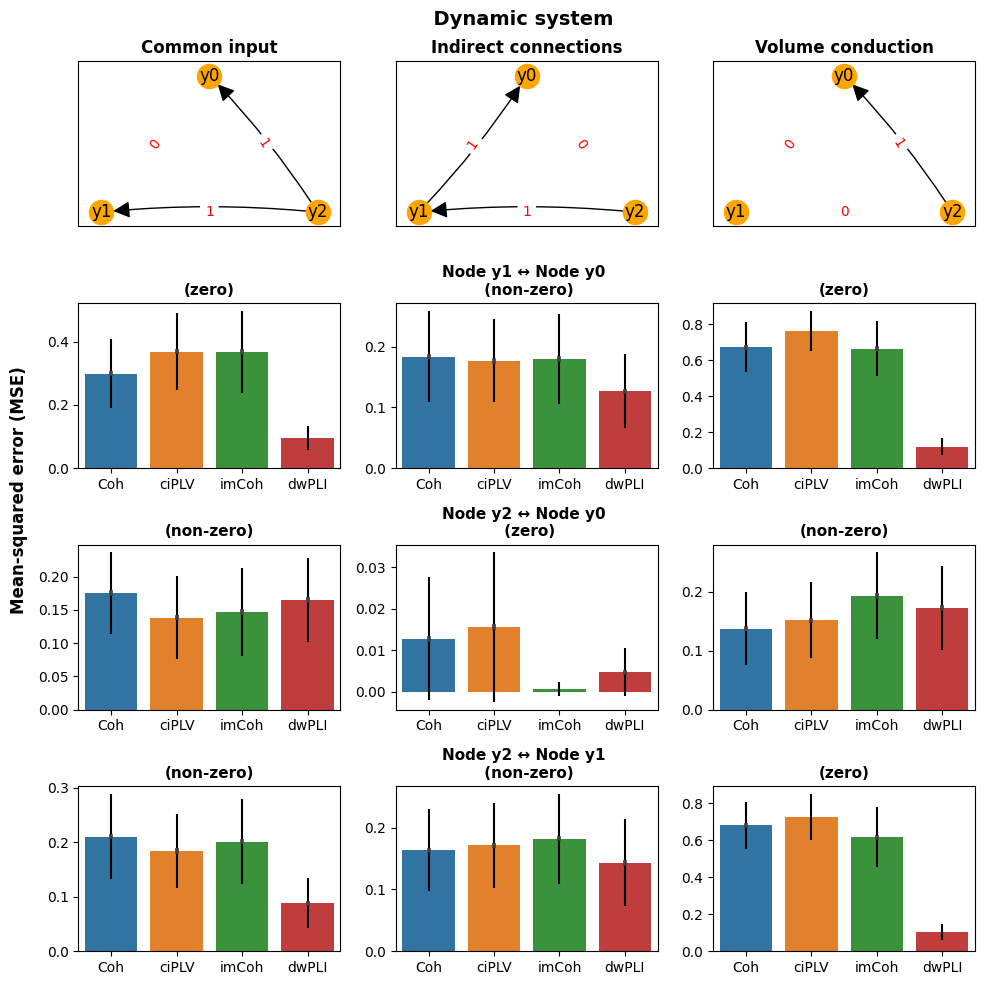

In [19]:
#FUNCTIONAL

fig, axes = plt.subplots(4,3,figsize=(10,10))

###### Ground truth ################


edge_list_1 = [('y0','y1',{'w':'A1'}),('y1','y2',{'w':'B1'}),('y0','y2',{'w':'C1'})]

edge_list_2 = [('y1','y0',{'w':'A2'}),('y2','y1',{'w':'B2'}),('y2','y0',{'w':'C2'})]

G = nx.DiGraph()

G.add_edges_from(edge_list_1)
pos=nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05


nx.draw_networkx_edges(G, pos, ax=axes[0][0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0][0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,1,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0][0], edge_labels={('y1','y0'):0,('y2','y1'):1,('y2','y0'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0][0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0][0])

axes[0][0].set_title("Common input", fontsize=12, fontweight="bold")

nx.draw_networkx_edges(G, pos, ax=axes[0][1], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0][1], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[1,1,0],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0][1], edge_labels={('y1','y0'):1,('y2','y1'):1,('y2','y0'):0},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0][1],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0][1])

axes[0][1].set_title("Indirect connections", fontsize=12, fontweight="bold")

nx.draw_networkx_edges(G, pos, ax=axes[0][2], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0][2], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0][2], edge_labels={('y1','y0'):0,('y2','y1'):0,('y2','y0'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0][2],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0][2])

axes[0][2].set_title("Volume conduction", fontsize=12, fontweight="bold")

#########Common input###########

plot_bar_from_dict("common_input", axes[1][0], mse_dict, "zero_1_0", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "(zero)")
plot_bar_from_dict("common_input", axes[2][0], mse_dict, "non-zero_2_0", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "(non-zero)")
plot_bar_from_dict("common_input", axes[3][0], mse_dict, "non-zero_2_1", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "(non-zero)")


#########Indirect connection###########

plot_bar_from_dict("indirect_connections", axes[1][1], mse_dict, "non-zero_1_0", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y1 ↔ Node y0 \n (non-zero)")
plot_bar_from_dict("indirect_connections", axes[2][1], mse_dict, "zero_2_0", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y2 ↔ Node y0 \n (zero)")
plot_bar_from_dict("indirect_connections", axes[3][1], mse_dict, "non-zero_2_1", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y2 ↔ Node y1 \n (non-zero)")


######### Volume conduction ###########

plot_bar_from_dict("volume_conduction", axes[1][2], mse_dict, "zero_1_0", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "(zero)")
plot_bar_from_dict("volume_conduction", axes[2][2], mse_dict, "non-zero_2_0", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "(non-zero)")
plot_bar_from_dict("volume_conduction", axes[3][2], mse_dict, "zero_2_1", undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "(zero)")

fig.supylabel("Mean-squared error (MSE)",fontsize=12, fontweight="bold")
fig.suptitle("          Dynamic system", fontweight="bold",fontsize=14)

fig.tight_layout()
plt.savefig("/scratch/figures/mse_func_dyn.png",dpi=300)

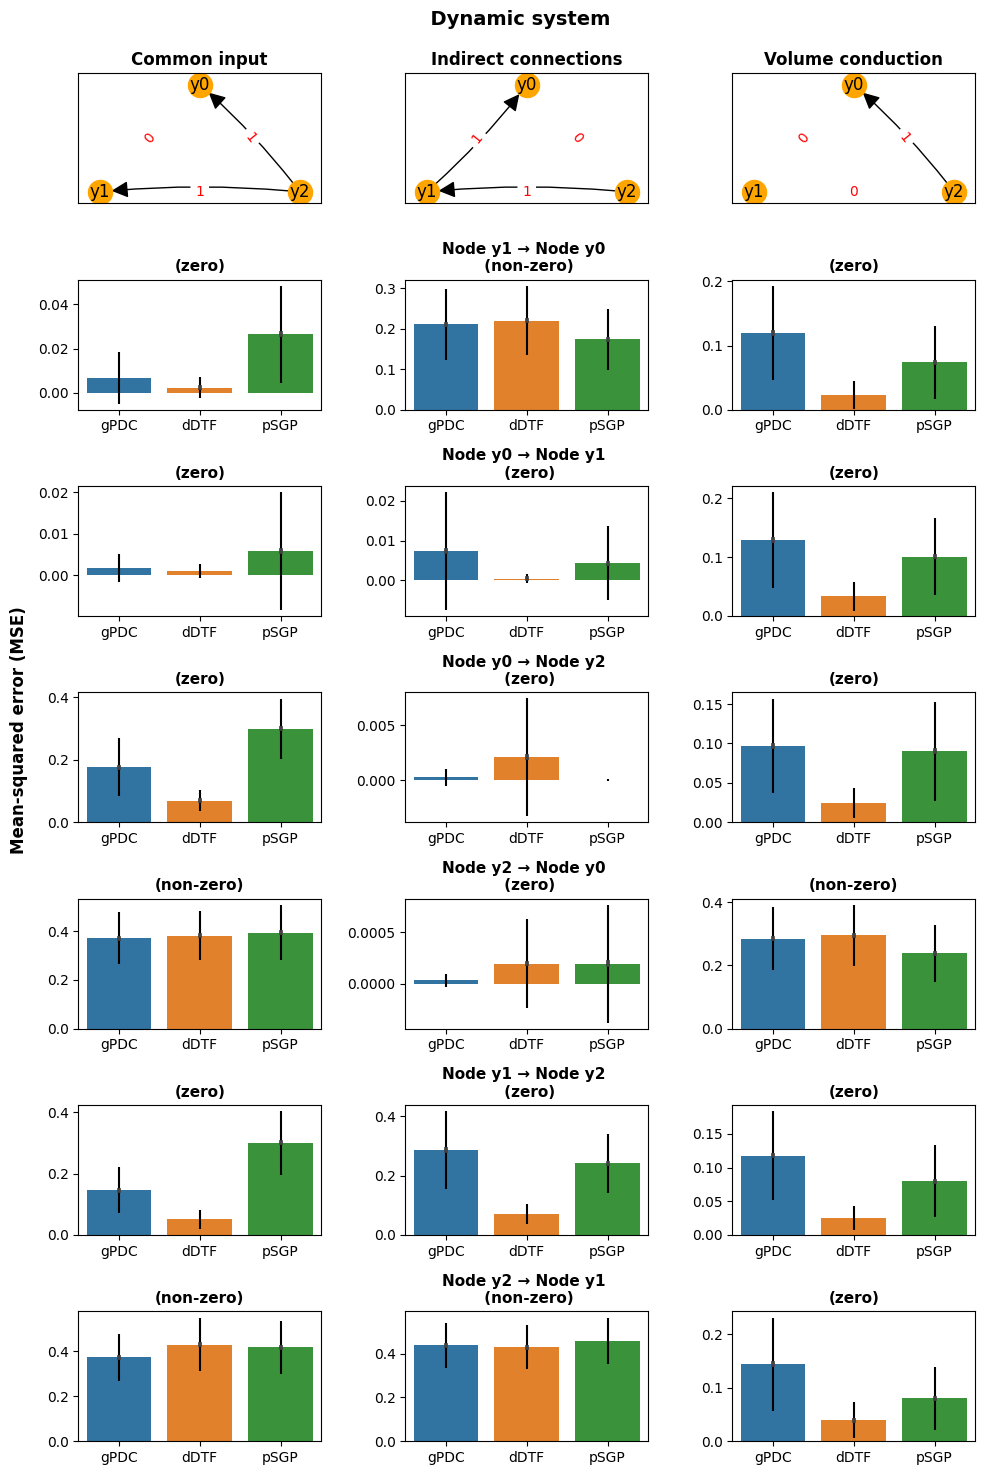

In [20]:
fig, axes = plt.subplots(7,3,figsize=(10,15))

###### Ground truth ################


edge_list_1 = [('y0','y1',{'w':'A1'}),('y1','y2',{'w':'B1'}),('y0','y2',{'w':'C1'})]

edge_list_2 = [('y1','y0',{'w':'A2'}),('y2','y1',{'w':'B2'}),('y2','y0',{'w':'C2'})]

G = nx.DiGraph()

G.add_edges_from(edge_list_1)
pos=nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05


nx.draw_networkx_edges(G, pos, ax=axes[0][0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0][0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,1,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0][0], edge_labels={('y1','y0'):0,('y2','y1'):1,('y2','y0'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0][0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0][0])

axes[0][0].set_title("Common input", fontsize=12, fontweight="bold")

nx.draw_networkx_edges(G, pos, ax=axes[0][1], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0][1], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[1,1,0],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0][1], edge_labels={('y1','y0'):1,('y2','y1'):1,('y2','y0'):0},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0][1],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0][1])

axes[0][1].set_title("Indirect connections", fontsize=12, fontweight="bold")

nx.draw_networkx_edges(G, pos, ax=axes[0][2], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0][2], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0][2], edge_labels={('y1','y0'):0,('y2','y1'):0,('y2','y0'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0][2],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0][2])

axes[0][2].set_title("Volume conduction", fontsize=12, fontweight="bold")

###### Common input ###### 

plot_bar_from_dict("common_input", axes[1][0], mse_dict, 'zero_1_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")
plot_bar_from_dict("common_input", axes[2][0], mse_dict, 'zero_0_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")

plot_bar_from_dict("common_input", axes[3][0], mse_dict, 'zero_0_2', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")
plot_bar_from_dict("common_input", axes[4][0], mse_dict, 'non-zero_2_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "(non-zero)")

plot_bar_from_dict("common_input", axes[5][0], mse_dict, 'zero_1_2', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")
plot_bar_from_dict("common_input", axes[6][0], mse_dict, 'non-zero_2_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "(non-zero)")

###### Indirect connection ######

plot_bar_from_dict("indirect_connections", axes[1][1], mse_dict, 'non-zero_1_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y1 → Node y0 \n (non-zero)")
plot_bar_from_dict("indirect_connections", axes[2][1], mse_dict, 'zero_0_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y0 → Node y1 \n (zero)")

plot_bar_from_dict("indirect_connections", axes[3][1], mse_dict, 'zero_0_2', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y0 → Node y2 \n (zero)")
plot_bar_from_dict("indirect_connections", axes[4][1], mse_dict, 'zero_2_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y2 → Node y0 \n (zero)")


plot_bar_from_dict("indirect_connections", axes[5][1], mse_dict, 'zero_1_2', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y1 → Node y2 \n (zero)")
plot_bar_from_dict("indirect_connections", axes[6][1], mse_dict, 'non-zero_2_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y2 → Node y1 \n (non-zero)")

###### Volume conduction #######

plot_bar_from_dict("volume_conduction", axes[1][2], mse_dict, 'zero_1_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")
plot_bar_from_dict("volume_conduction", axes[2][2], mse_dict, 'zero_0_1', directed_methods, ["gPDC", "dDTF", "pSGP"],  "(zero)")

plot_bar_from_dict("volume_conduction", axes[3][2], mse_dict, 'zero_0_2', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")
plot_bar_from_dict("volume_conduction", axes[4][2], mse_dict, 'non-zero_2_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "(non-zero)")


plot_bar_from_dict("volume_conduction", axes[5][2], mse_dict, 'zero_1_2', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")
plot_bar_from_dict("volume_conduction", axes[6][2], mse_dict, 'zero_2_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "(zero)")

fig.suptitle("          Dynamic system \n", fontweight="bold",fontsize=14)
fig.supylabel("Mean-squared error (MSE)",fontsize=12, fontweight="bold")
fig.tight_layout()
plt.savefig("/scratch/figures/mse_eff_dyn.png",dpi=300)

## GRAPHS - CORR COEF

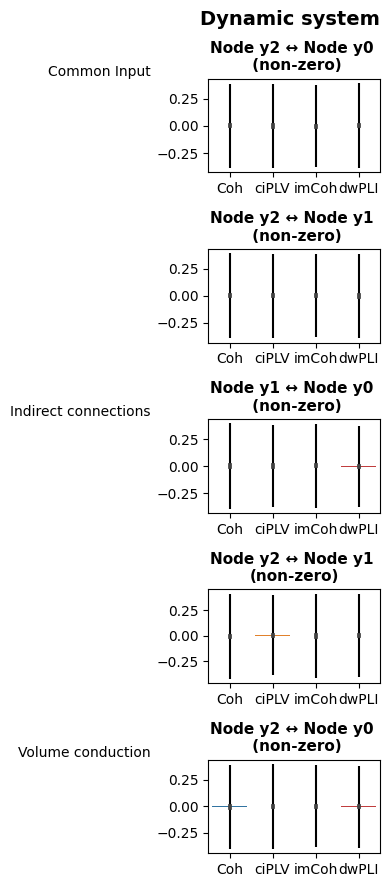

In [15]:
#FUNCTIONAL
fig, axes = plt.subplots(5,1,figsize=(4,9))

plot_bar_from_dict("common_input", axes[0], corr_coef_dict, 'non-zero_2_0', undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y2 ↔ Node y0 \n (non-zero)")
plot_bar_from_dict("common_input", axes[1], corr_coef_dict, 'non-zero_2_1', undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y2 ↔ Node y1 \n (non-zero)")

plot_bar_from_dict("indirect_connections", axes[2], corr_coef_dict, 'non-zero_1_0', undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y1 ↔ Node y0 \n (non-zero)")
plot_bar_from_dict("indirect_connections", axes[3], corr_coef_dict, 'non-zero_2_1', undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y2 ↔ Node y1 \n(non-zero)")

plot_bar_from_dict("volume_conduction", axes[4], corr_coef_dict, 'non-zero_2_0', undirected_methods, ["Coh", "ciPLV", "imCoh", "dwPLI"], "Node y2 ↔ Node y0 \n (non-zero)")

axes[0].set_ylabel('Common Input', rotation = 'horizontal',fontsize=10, loc='top')
axes[2].set_ylabel('Indirect connections', rotation = 'horizontal',fontsize=10, loc='top')
axes[4].set_ylabel('Volume conduction', rotation = 'horizontal',fontsize=10, loc='top')

fig.suptitle("                            Dynamic system", fontweight="bold",fontsize=14)
fig.tight_layout()
plt.savefig("/scratch/figures/corr_func_dyn.png",dpi=300)

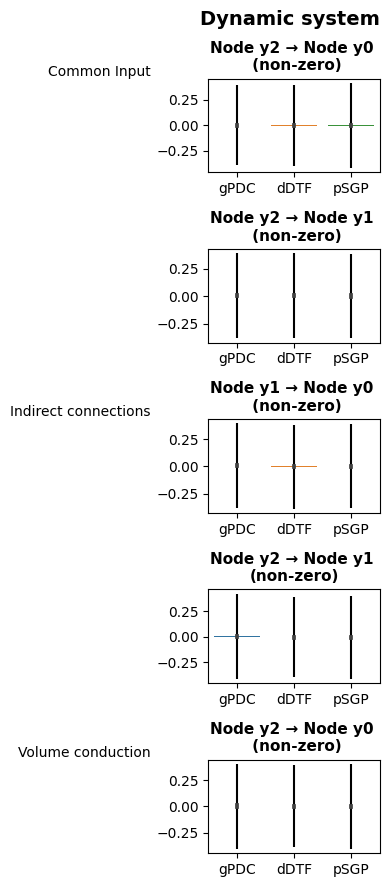

In [16]:
#EFFECTIVE
fig, axes = plt.subplots(5,1,figsize=(4,9))

plot_bar_from_dict("common_input", axes[0], corr_coef_dict, 'non-zero_2_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y2 → Node y0 \n (non-zero)")
plot_bar_from_dict("common_input", axes[1], corr_coef_dict, 'non-zero_2_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y2 → Node y1 \n (non-zero)")

plot_bar_from_dict("indirect_connections", axes[2], corr_coef_dict, 'non-zero_1_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y1 → Node y0 \n (non-zero)")
plot_bar_from_dict("indirect_connections", axes[3], corr_coef_dict, 'non-zero_2_1', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y2 → Node y1 \n(non-zero)")

plot_bar_from_dict("volume_conduction", axes[4], corr_coef_dict, 'non-zero_2_0', directed_methods, ["gPDC", "dDTF", "pSGP"], "Node y2 → Node y0 \n (non-zero)")

axes[0].set_ylabel('Common Input', rotation = 'horizontal',fontsize=10, loc='top')
axes[2].set_ylabel('Indirect connections', rotation = 'horizontal',fontsize=10, loc='top')
axes[4].set_ylabel('Volume conduction', rotation = 'horizontal',fontsize=10, loc='top')

fig.suptitle("                            Dynamic system", fontweight="bold",fontsize=14)
fig.tight_layout()
plt.savefig("/scratch/figures/corr_eff_dyn.png",dpi=300)

### 95% CONFIDENCE INTERVALS ###

In [17]:
comparison_pairs = [('coh','ciplv'), 
                    ('coh','imaginary_coherence'), 
                    ('coh','wpli2_debiased'), 
                    ('ciplv','imaginary_coherence'),
                    ('ciplv','wpli2_debiased'),
                    ('imaginary_coherence','wpli2_debiased'),
                   ('direct_directed_transfer_function','generalized_partial_directed_coherence'),
                    ('direct_directed_transfer_function','pairwise_spectral_granger_prediction'),
                    ('generalized_partial_directed_coherence','pairwise_spectral_granger_prediction')]

In [18]:
ci_dict_mse = {}
ci_dict_corr = {}

for confounder in confounder_list:

    confounder_dict_mse = {}
    
    confounder_dict_corr = {}
    
    for pair in comparison_pairs:

        connections = overall_estimate_dict[confounder][pair[0]].keys()
        
        pair_dict_mse = {}
        
        pair_dict_corr = {}
        
        for connection in connections:
            
            group_1 = np.array(mse_dict[confounder][pair[0]][connection])
            group_1.sort()
            group_2 = np.array(mse_dict[confounder][pair[1]][connection])
            group_2.sort()
            diff_list = group_2 - group_1
            diff_list.sort()
            perc_025 = np.round(diff_list[24],3)
            perc_975 = np.round(diff_list[974],3)

            pair_dict_mse[connection] = (perc_025, perc_975)


            group_1 = np.array(corr_coef_dict[confounder][pair[0]][connection])
            group_2 = np.array(corr_coef_dict[confounder][pair[1]][connection])
            diff_list = group_2 - group_1
            diff_list.sort()
            perc_025 = np.round(diff_list[24],3)
            perc_975 = np.round(diff_list[974],3)

            pair_dict_corr[connection] = (perc_025, perc_975)

        if pair == ('direct_directed_transfer_function','generalized_partial_directed_coherence'):
            pair = ('dDTF','gPDC')

        elif pair == ('direct_directed_transfer_function','pairwise_spectral_granger_prediction'):
            pair = ('dDTF','pSGP')

        elif pair == ('generalized_partial_directed_coherence','pairwise_spectral_granger_prediction'):
            pair = ('gPDC','pSGP')
            
        confounder_dict_mse[pair] = pair_dict_mse

        confounder_dict_corr[pair] = pair_dict_corr

    ci_dict_mse[confounder] = confounder_dict_mse
    
    ci_dict_corr[confounder] = confounder_dict_corr


In [19]:
df_list = []
for confounder in confounder_list:
    df1 = pd.DataFrame(list(ci_dict_mse[confounder].keys())[0:6])
    df1['Pairs'] = df1[0] + "-" + df1[1]
    df1 = df1.drop(0, axis=1)
    df1 = df1.drop(1, axis=1)
    df2 = pd.DataFrame(list(ci_dict_mse[confounder].values())[0:6])
    df3 = df1.join(df2, how="right")
    df3.insert(0,"Confounder","")
    df3["Confounder"].iloc[0] = confounder
    df_list.append(df3)
    

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1372/2382414182.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df3["Confounder"].iloc[0] = confounder
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1372/2382414182

In [27]:
df_list[0] = df_list[0].rename(columns = {"zero_1_0": "Node 1 ↔ Node 0", "non-zero_2_0":"Node 2 ↔ Node 0", "non-zero_2_1":"Node 2 ↔ Node 1"})

In [28]:
df_list[0]

,Confounder,Pairs,Node 1 ↔ Node 0,Node 2 ↔ Node 0,Node 2 ↔ Node 1
0,common_input,coh-ciplv,"(0.113, 0.147)","(0.009, 0.017)","(0.035, 0.046)"
1,,coh-imaginary_coherence,"(-0.186, -0.112)","(0.008, 0.025)","(0.013, 0.029)"
2,,coh-wpli2_debiased,"(0.031, 0.067)","(0.077, 0.114)","(0.064, 0.092)"
3,,ciplv-imaginary_coherence,"(-0.334, -0.225)","(-0.001, 0.007)","(-0.022, -0.016)"
4,,ciplv-wpli2_debiased,"(-0.084, -0.076)","(0.068, 0.096)","(0.028, 0.045)"
5,,imaginary_coherence-wpli2_debiased,"(0.145, 0.254)","(0.069, 0.089)","(0.052, 0.063)"


In [29]:
df_list[1] = df_list[1].rename(columns = {"non-zero_1_0": "Node 1 ↔ Node 0", "zero_2_0":"Node 2 ↔ Node 0", "non-zero_2_1":"Node 2 ↔ Node 1"})

In [30]:
df_list[1]

,Confounder,Pairs,Node 1 ↔ Node 0,Node 2 ↔ Node 0,Node 2 ↔ Node 1
0,indirect_connections,coh-ciplv,"(0.004, 0.008)","(0.158, 0.232)","(0.047, 0.063)"
1,,coh-imaginary_coherence,"(-0.022, -0.018)","(0.001, 0.025)","(0.008, 0.025)"
2,,coh-wpli2_debiased,"(0.055, 0.074)","(0.051, 0.11)","(0.092, 0.119)"
3,,ciplv-imaginary_coherence,"(-0.028, -0.024)","(-0.232, -0.133)","(-0.041, -0.036)"
4,,ciplv-wpli2_debiased,"(0.048, 0.069)","(-0.122, -0.106)","(0.045, 0.059)"
5,,imaginary_coherence-wpli2_debiased,"(0.073, 0.095)","(0.025, 0.111)","(0.085, 0.095)"


In [31]:
df_list[2] = df_list[2].rename(columns = {"zero_1_0": "Node 1 ↔ Node 0", "non-zero_2_0":"Node 2 ↔ Node 0", "zero_2_1":"Node 2 ↔ Node 1"})

In [32]:
df_list[2]

,Confounder,Pairs,Node 1 ↔ Node 0,Node 2 ↔ Node 0,Node 2 ↔ Node 1
0,volume_conduction,coh-ciplv,"(-0.004, 0.022)","(-0.019, -0.016)","(0.115, 0.145)"
1,,coh-imaginary_coherence,"(-0.605, -0.496)","(0.005, 0.012)","(-0.557, -0.444)"
2,,coh-wpli2_debiased,"(-0.194, -0.16)","(0.036, 0.056)","(-0.108, -0.09)"
3,,ciplv-imaginary_coherence,"(-0.601, -0.521)","(0.024, 0.029)","(-0.672, -0.59)"
4,,ciplv-wpli2_debiased,"(-0.218, -0.155)","(0.054, 0.072)","(-0.251, -0.206)"
5,,imaginary_coherence-wpli2_debiased,"(0.302, 0.445)","(0.031, 0.044)","(0.339, 0.465)"


In [20]:
df_list = []
for confounder in confounder_list:
    df1 = pd.DataFrame(list(ci_dict_mse[confounder].keys())[6:])
    df1['Pairs'] = df1[0] + "-" + df1[1]
    df1 = df1.drop(0, axis=1)
    df1 = df1.drop(1, axis=1)
    df2 = pd.DataFrame(list(ci_dict_mse[confounder].values())[6:])
    df3 = df1.join(df2, how="right")
    df3.insert(0,"Confounder","")
    df3["Confounder"].iloc[0] = confounder
    df_list.append(df3)
    

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1372/1255666599.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df3["Confounder"].iloc[0] = confounder
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1372/1255666599

In [21]:
df_list[0] = df_list[0].rename(columns = {"zero_1_0": "Node 1 → Node 0", "non-zero_2_0":"Node 2 → Node 0", "non-zero_2_1":"Node 2 → Node 1", 
                                         "zero_0_1":"Node 0 → Node 1", "zero_0_2":"Node 0 → Node 2", "zero_1_2":"Node 1 → Node 2"})

In [22]:
df_list[0]

,Confounder,Pairs,Node 1 → Node 0,Node 2 → Node 0,Node 2 → Node 1,Node 0 → Node 1,Node 0 → Node 2,Node 1 → Node 2
0,common_input,dDTF-gPDC,"(0.001, 0.013)","(0.0, 0.009)","(-0.038, -0.033)","(0.0, 0.004)","(0.078, 0.133)","(0.059, 0.105)"
1,,dDTF-pSGP,"(0.027, 0.058)","(-0.036, -0.029)","(-0.023, -0.015)","(0.0, 0.002)","(0.194, 0.265)","(0.21, 0.279)"
2,,gPDC-pSGP,"(0.027, 0.045)","(-0.041, -0.034)","(0.012, 0.02)","(-0.001, 0.0)","(0.116, 0.133)","(0.151, 0.175)"


In [23]:
df_list[1] = df_list[1].rename(columns = {"non-zero_1_0": "Node 1 → Node 0", "zero_2_0":"Node 2 → Node 0", "non-zero_2_1":"Node 2 → Node 1", 
                                         "zero_0_1":"Node 0 → Node 1", "zero_0_2":"Node 0 → Node 2", "zero_1_2":"Node 1 → Node 2"})

In [24]:
df_list[1]

,Confounder,Pairs,Node 1 → Node 0,Node 2 → Node 0,Node 2 → Node 1,Node 0 → Node 1,Node 0 → Node 2,Node 1 → Node 2
0,indirect_connections,dDTF-gPDC,"(-0.054, -0.038)","(-0.0, -0.0)","(-0.083, -0.076)","(0.001, 0.012)","(-0.0, -0.0)","(0.157, 0.24)"
1,,dDTF-pSGP,"(-0.03, -0.022)","(-0.0, 0.0)","(-0.059, -0.052)","(0.0, 0.009)","(0.0, 0.002)","(0.111, 0.166)"
2,,gPDC-pSGP,"(0.014, 0.026)","(0.0, 0.0)","(0.02, 0.027)","(-0.003, -0.001)","(0.0, 0.002)","(-0.073, -0.047)"


In [25]:
df_list[2] = df_list[2].rename(columns = {"zero_1_0": "Node 1 → Node 0", "non-zero_2_0":"Node 2 → Node 0", "zero_2_1":"Node 2 → Node 1", 
                                         "zero_0_1":"Node 0 → Node 1", "zero_0_2":"Node 0 → Node 2", "zero_1_2":"Node 1 → Node 2"})

In [26]:
df_list[2]

,Confounder,Pairs,Node 1 → Node 0,Node 2 → Node 0,Node 2 → Node 1,Node 0 → Node 1,Node 0 → Node 2,Node 1 → Node 2
0,volume_conduction,dDTF-gPDC,"(0.065, 0.108)","(-0.071, -0.057)","(0.075, 0.135)","(0.061, 0.096)","(0.077, 0.151)","(0.061, 0.101)"
1,,dDTF-pSGP,"(0.044, 0.064)","(-0.018, -0.011)","(0.04, 0.073)","(0.023, 0.04)","(0.029, 0.057)","(0.028, 0.048)"
2,,gPDC-pSGP,"(-0.045, -0.023)","(0.046, 0.055)","(-0.062, -0.035)","(-0.056, -0.04)","(-0.094, -0.047)","(-0.054, -0.033)"
